In [1]:
%load_ext autoreload
%autoreload 2
import synapseclient as sc
import pandas as pd
import sys
import warnings
import nbconvert
sys.path.append("../../src")

import utils.query_utils as query
import utils.viz_utils as viz
import utils.preprocessing_utils as process
import seaborn as sns
import matplotlib.pyplot as plt

warnings.simplefilter("ignore")
sns.set_style("dark")
%matplotlib inline


syn = sc.login()

Welcome, aryton tediarjo!



# Introduction

This notebook explores how each PDKIT features are being distributed in each age groups.
The feature naming convention is {coordinate orientation}.name_of_the_feature. In this notebook we will explore how our subject from mpower version 1, mpower version 2, passive data (neglect for now) and elevateMS age affects the number of steps, freeze occurences and the speed of gait. We will also compare how each of the control fare against the PD and MS patients. Afterwards, we will see which of the feature is most predictive in terms of predicting PD and MS patients.

Analysis will be done per records, as well as by groupings of healthcode medians and maximum, as wild analysis can lead to a decrease in test performance when compared to in-study analysis (hawhthorne effect).


### Processing Steps:
In wiki

### Coordinate Orientation: 
 - <b> x  </b> : feature computation on x-axis
 - <b> y  </b> : feature computation on y-axis
 - <b> z  </b> : feature computation on z-axis
 - <b> AA </b>: feature computation on resultant signals
 - <b> FC </b>: feature combination of feature in x, y and z 

In [30]:
data = query.get_file_entity(syn, "syn21281633")

## add additional features ##
data = process.addFeatures().transform(data)

## grouped by median ##
median_grouped_data = process.collapseFeatures(aggregation_type = "median").transform(data)

## grouped by maximum ##
max_grouped_data = process.collapseFeatures(aggregation_type = "max").transform(data)

# Number of Record Ids on each groups

In [24]:
temp = data[["class", "version", "PD", "MS", "gender", "recordId"]]
temp.groupby(["class", "gender"]).count()["recordId"]

class                   gender
ems_case                female     2250
                        male       2224
ems_control             female      161
                        male         14
mpower_passive_case     female     5295
                        male      13978
mpower_passive_control  female     1606
                        male        263
mpower_v1_case          female    30345
                        male      40382
mpower_v1_control       female     5583
                        male      23835
mpower_v2_case          female     1692
                        male       2069
mpower_v2_control       female       76
                        male        206
Name: recordId, dtype: int64

# Some Summary Stats

In [25]:
non_duplicated = data.drop_duplicates(subset="healthCode", keep='first')

print("#### SUMMARY STATS ####\n")

print("Number of healthcodes : %s" %len(data["healthCode"].unique()))
print("Number of records     : %s" %data.shape[0])
print("Number of V1 data     : %s" %data[data["version"] == "mpower_v1"].shape[0])
print("Number of V2 data     : %s" %data[data["version"] == "mpower_v2"].shape[0])
print("Number of Passive data: %s" %data[data["version"] == "mpower_passive"].shape[0])
print("Number of EMS data    : %s" %data[data["version"] == "ems_active"].shape[0])
print("Number of controls    : %s" %non_duplicated[non_duplicated["is_control"] == 1].shape[0])
print("Number of cases       : %s" %non_duplicated[non_duplicated["is_control"] == 0].shape[0])

#### SUMMARY STATS ####

Number of healthcodes : 5328
Number of records     : 129979
Number of V1 data     : 100145
Number of V2 data     : 4043
Number of Passive data: 21142
Number of EMS data    : 4649
Number of controls    : 3504
Number of cases       : 1824


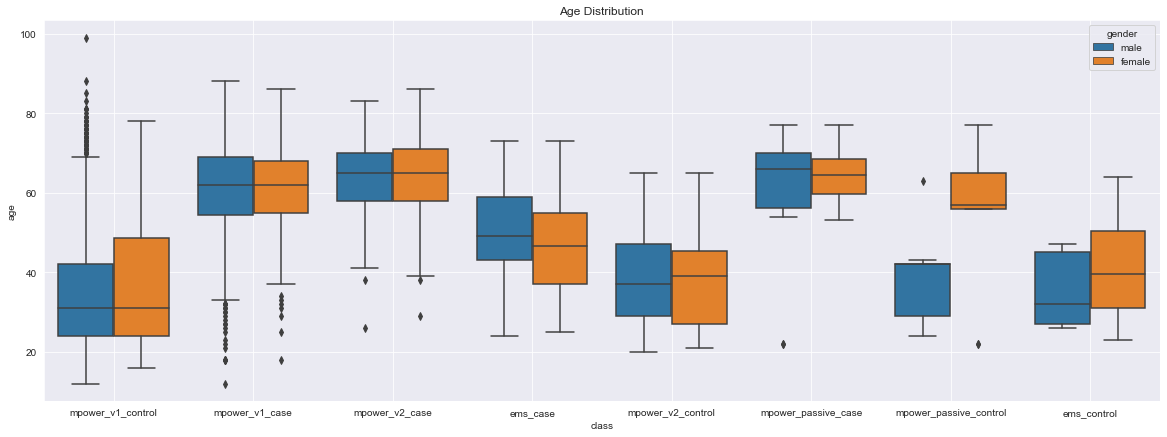

In [34]:
fig, axes = plt.subplots(nrows = 1, ncols = 1)

sns.boxplot(y = max_grouped_data["age"], x = max_grouped_data["class"], hue = max_grouped_data["gender"], ax = axes)
axes.set_title("Age Distribution")
axes.figure.set_size_inches(20,7)
axes.grid()

# Exploratory Data Analysis

## 1.) Distribution of Features in Controls Accross Age Bins (per records)

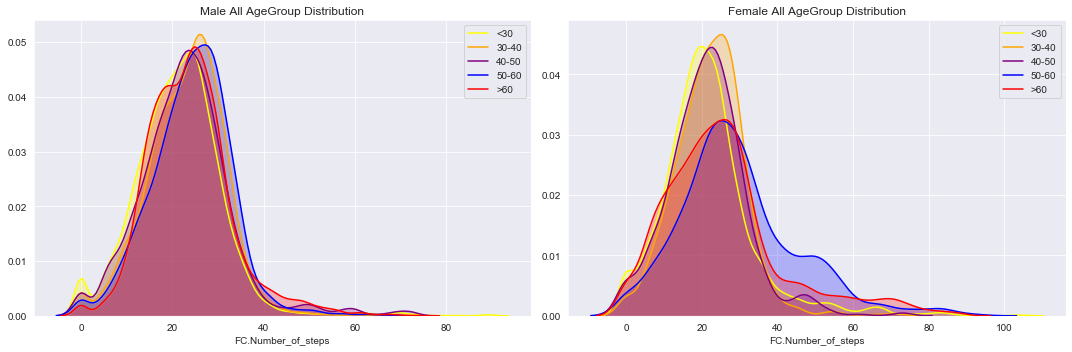

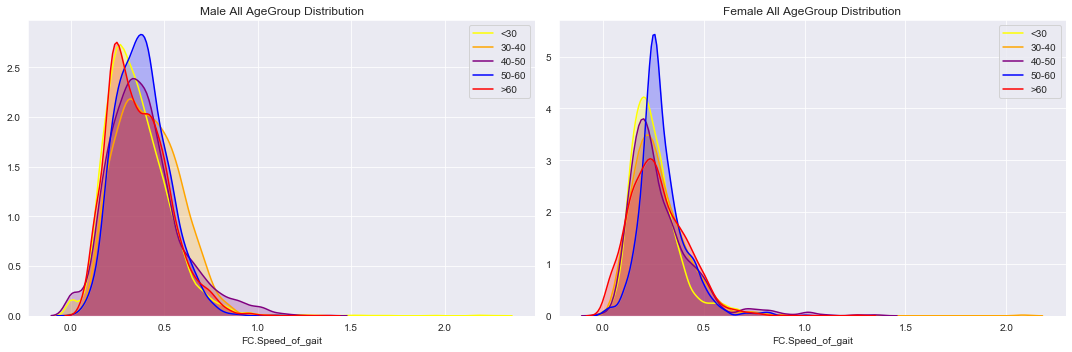

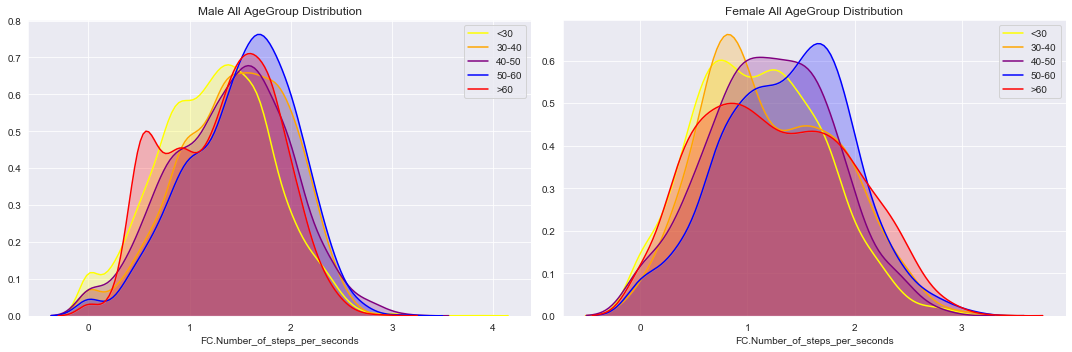

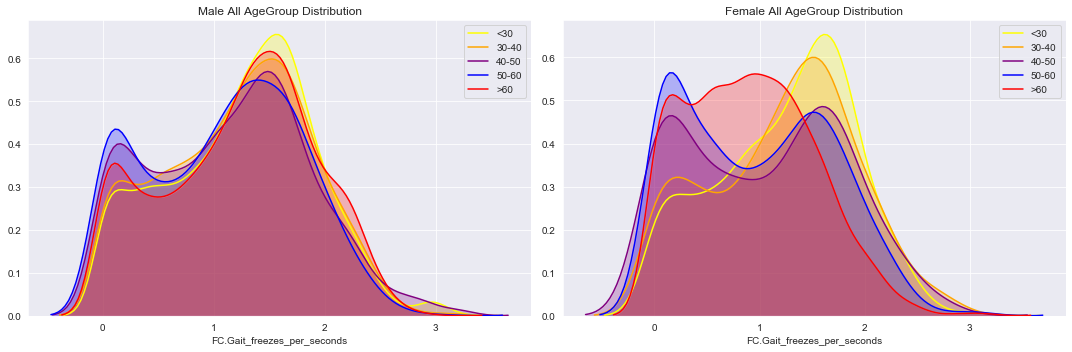

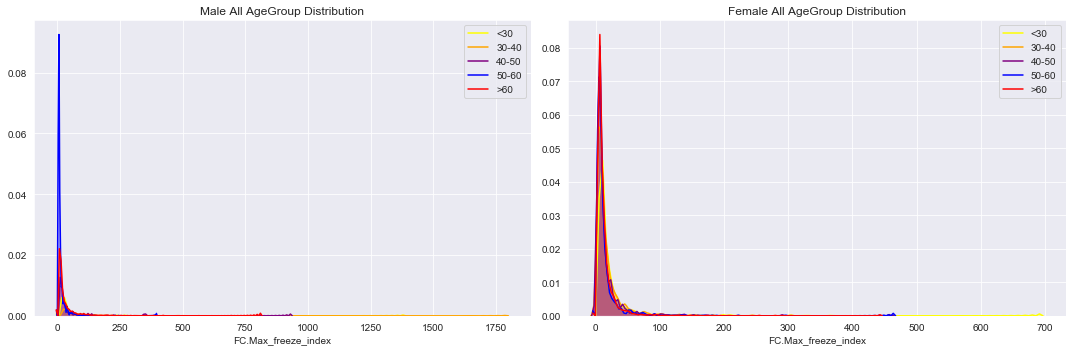

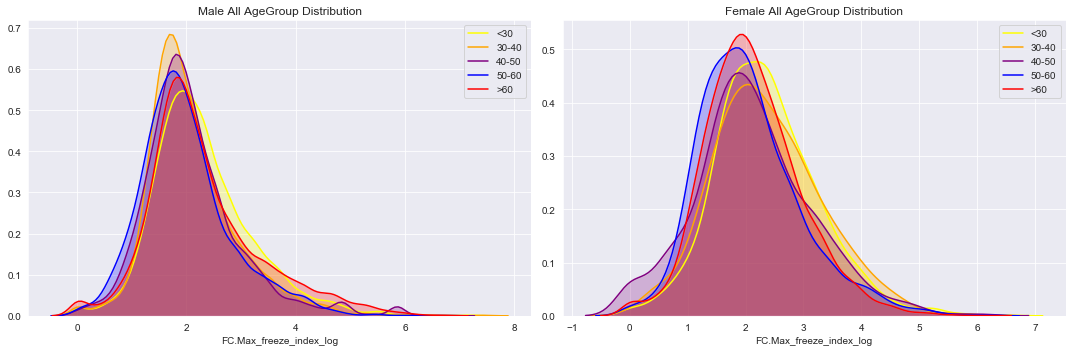

In [35]:
## Number of Steps
for feature in [feat for feat in data.columns if ("FC" in feat)]:
    viz.visualize_agegroups(data[(data["is_control"] == 1)], feature)

## 2.) Distribution of Feature Accross Subgroups (per healthCode median)

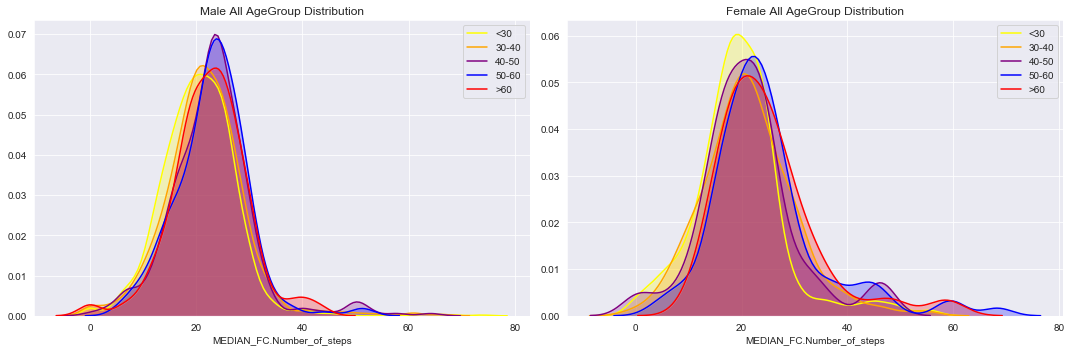

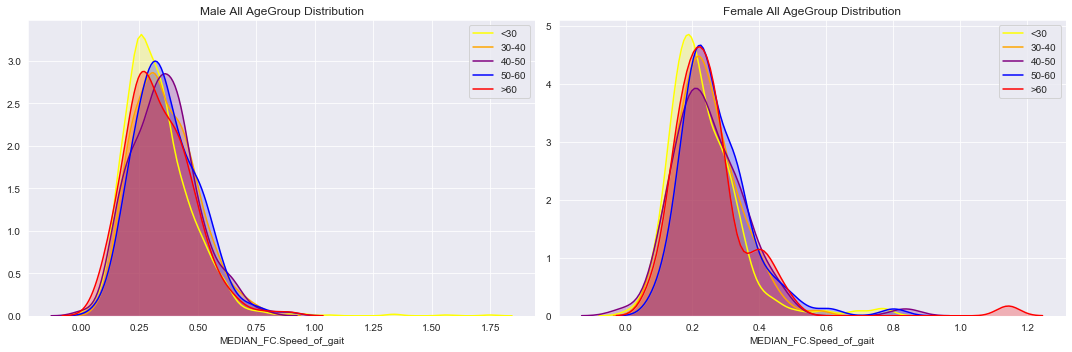

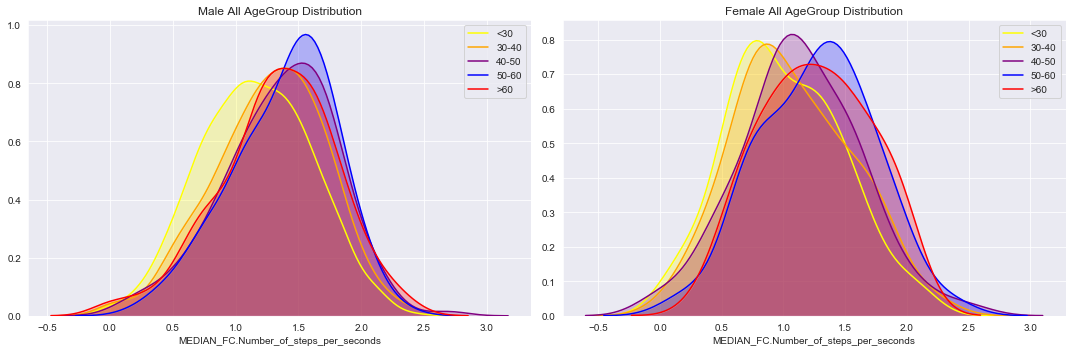

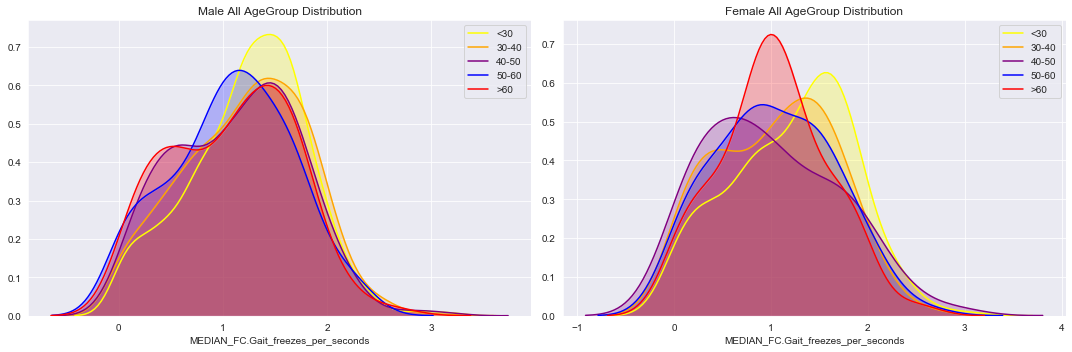

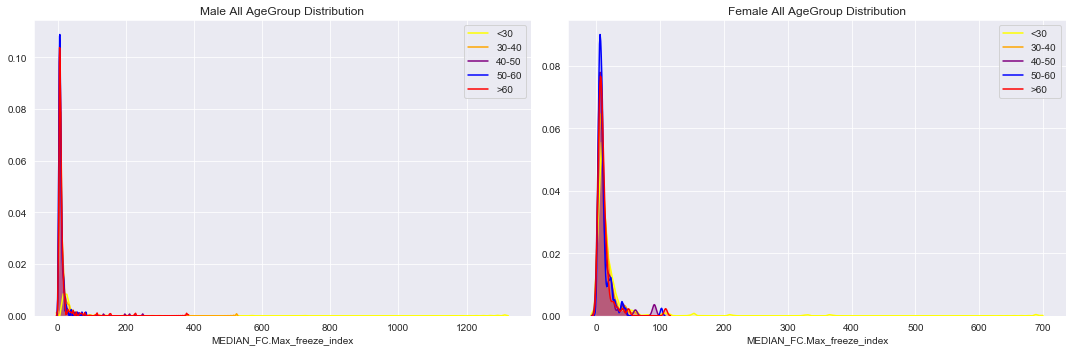

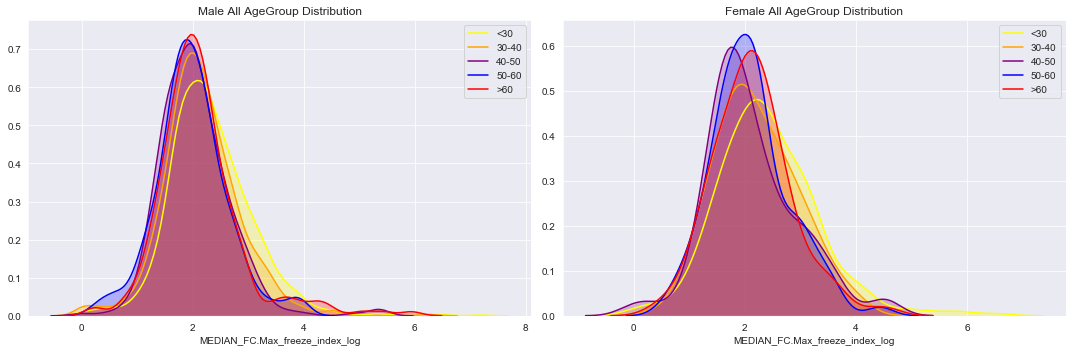

In [36]:
for feature in [feat for feat in median_grouped_data.columns if ("FC" in feat)]:
    viz.visualize_agegroups(median_grouped_data[(median_grouped_data["is_control"] == 1)], feature)

## 3.) Distribution of Feature Accross Subgroups (per healthCode Maximum)

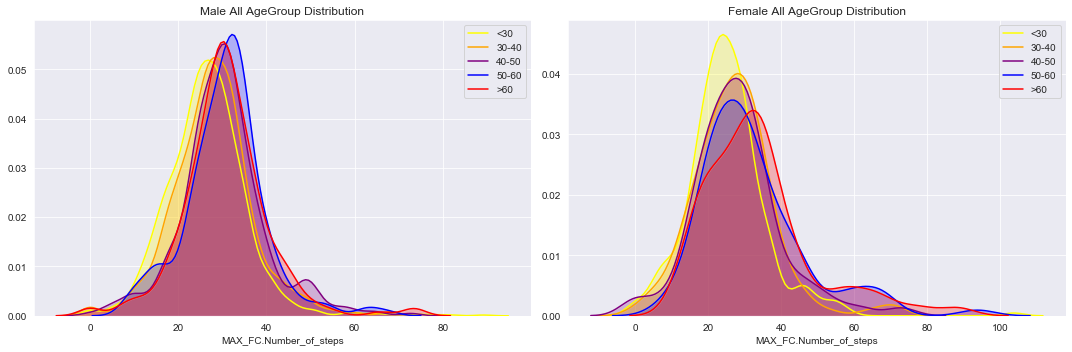

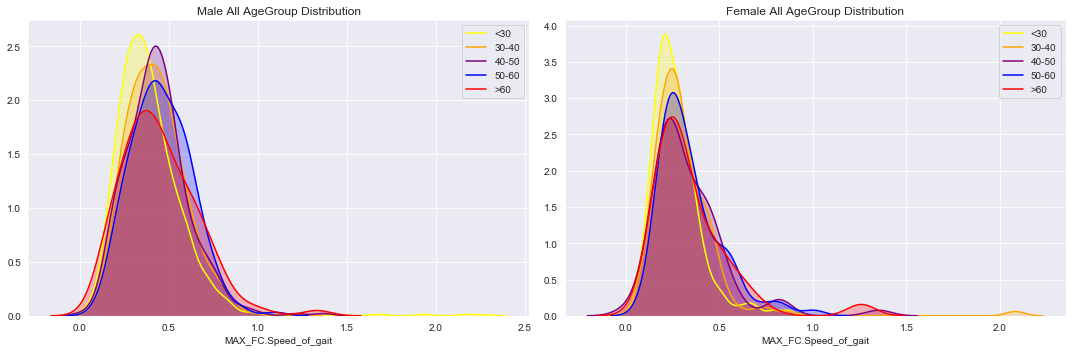

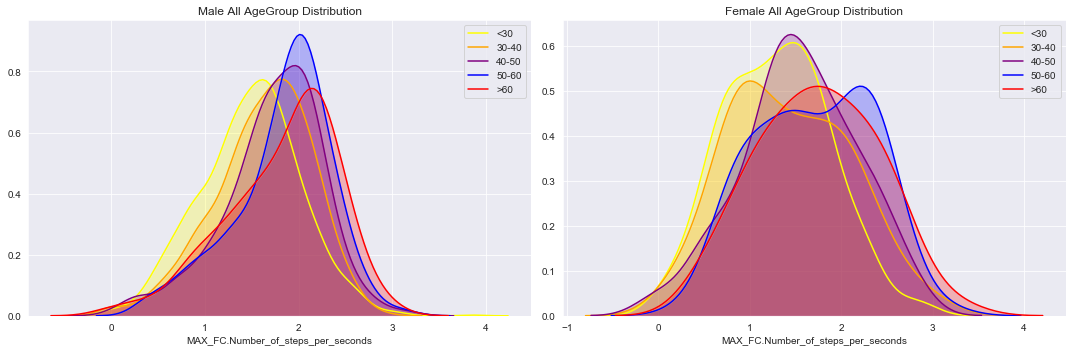

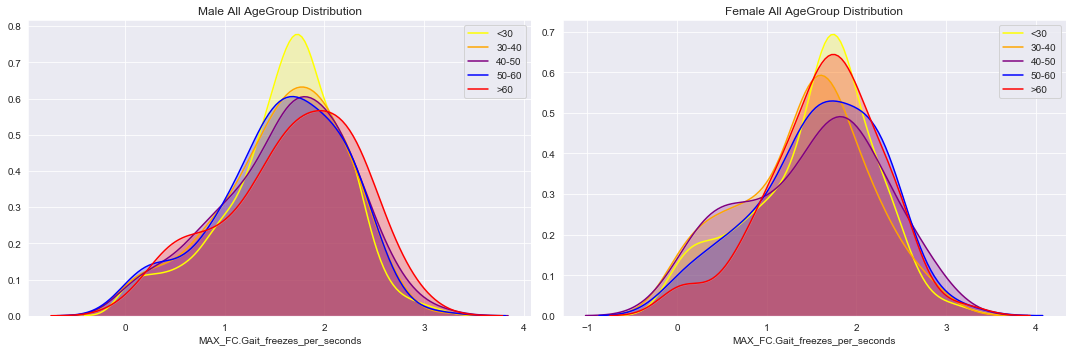

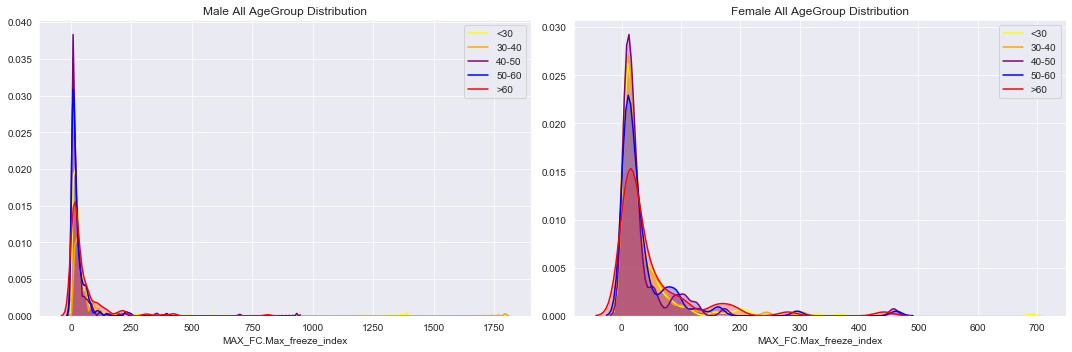

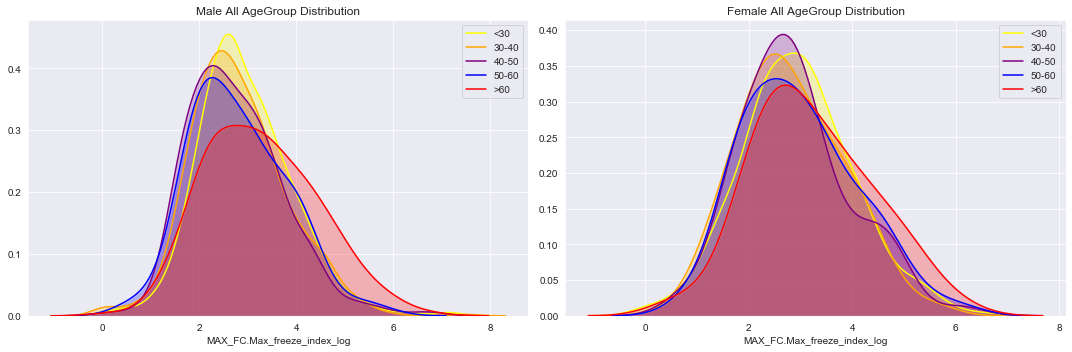

In [73]:
for feature in [feat for feat in max_grouped_data.columns if ("FC" in feat)]:
    viz.visualize_agegroups(max_grouped_data[(max_grouped_data["is_control"] == 1)], feature)

## 4.) Distribution of Control vs MS vs PD (per records)

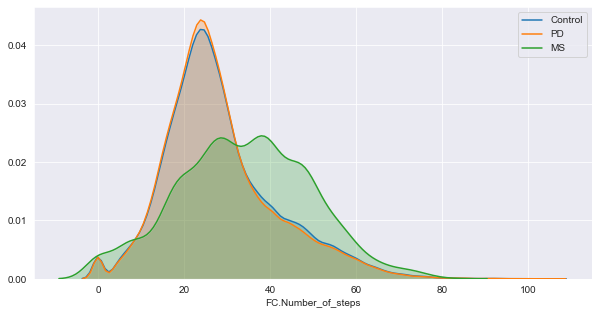

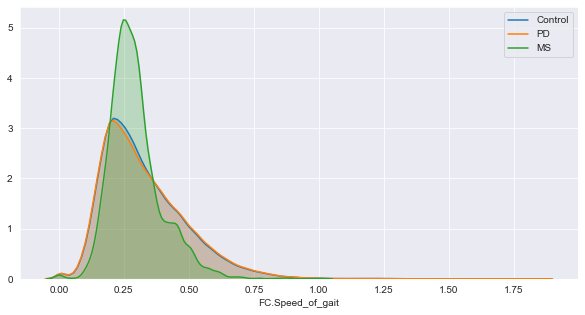

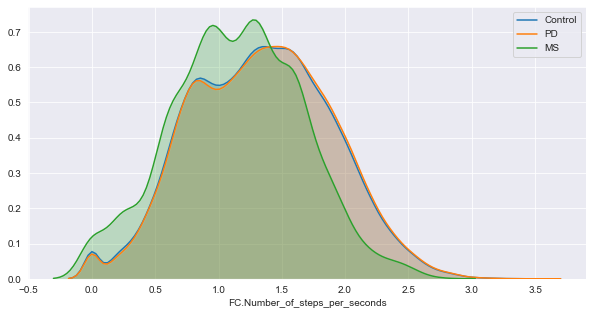

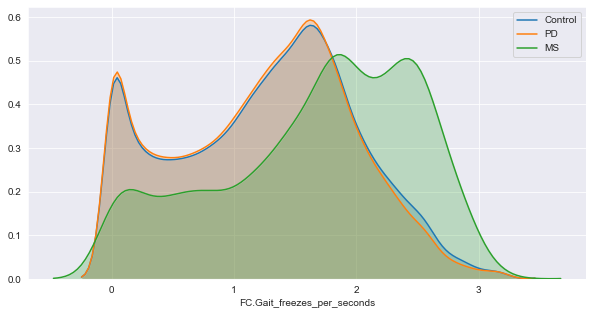

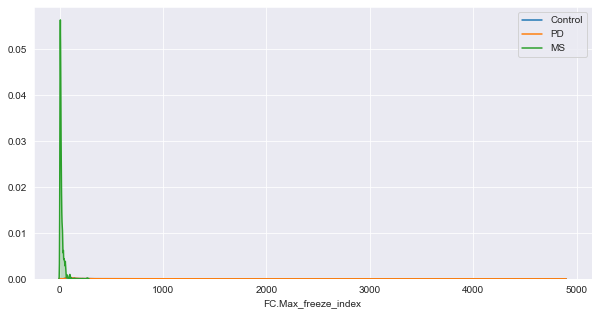

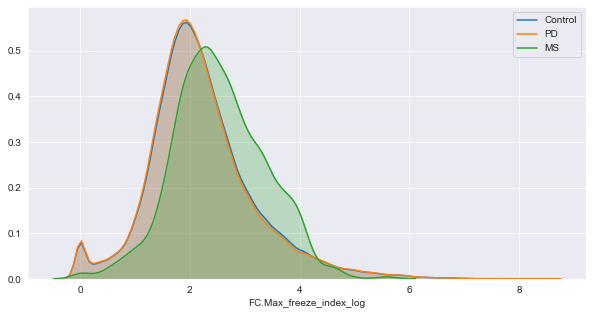

In [37]:
for feature in [feat for feat in data.columns if "FC" in feat]:
    viz.visualize_groupComparisons(data[data["version"] != "mpower_passive"], feature)

## 5.) Distribution of Control vs MS vs PD (per healthCodes median)

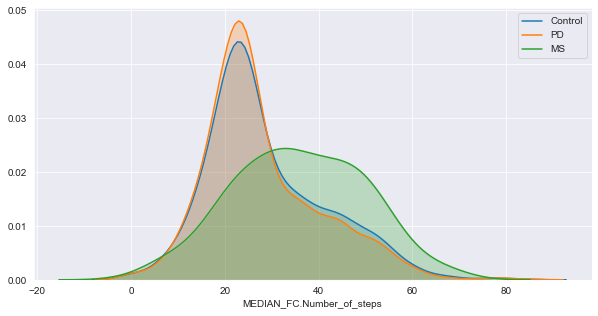

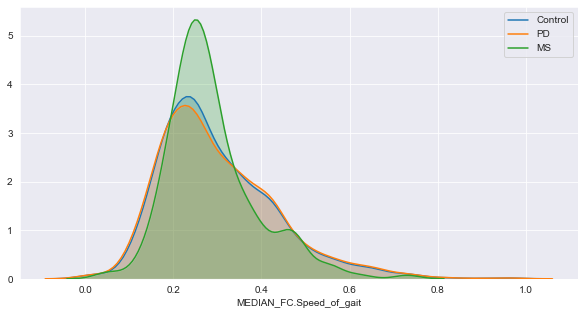

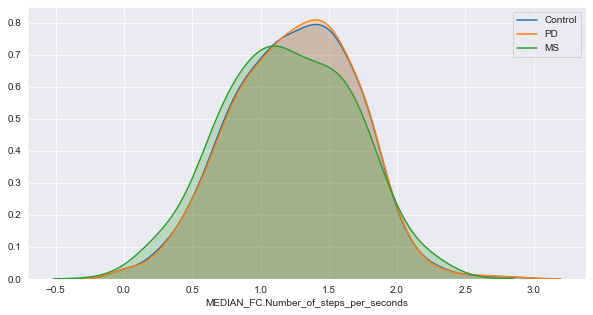

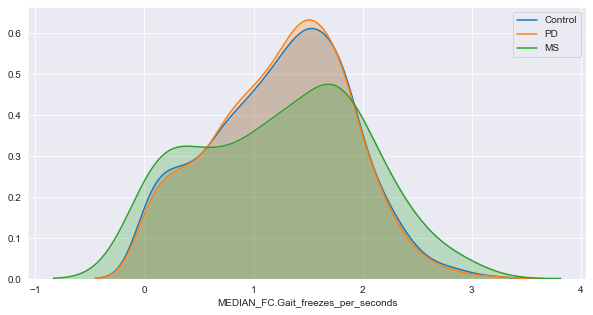

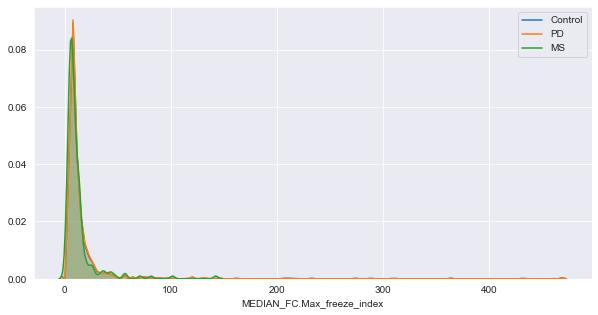

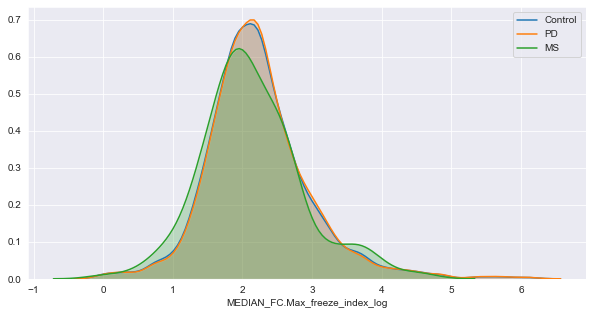

In [38]:
for feature in [feat for feat in median_grouped_data.columns if ("FC" in feat)]:
    viz.visualize_groupComparisons(median_grouped_data[median_grouped_data["version"] != "mpower_passive"], feature)

## 6.) Distribution of Control vs MS vs PD (per healthCode maximum)

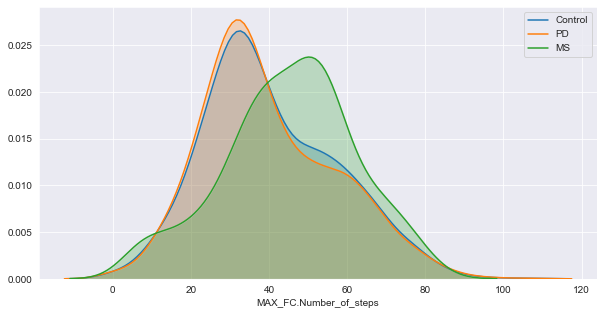

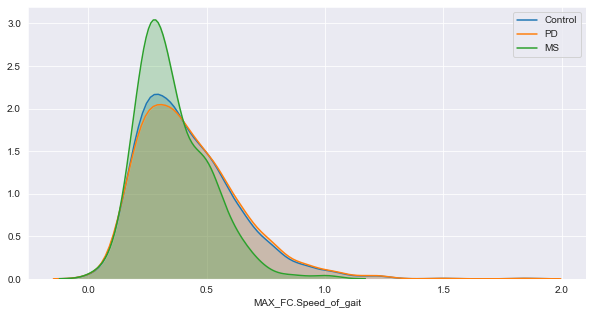

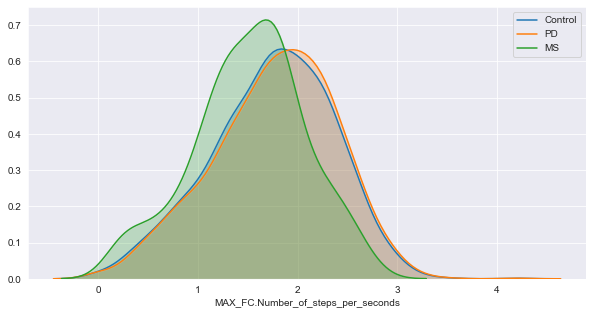

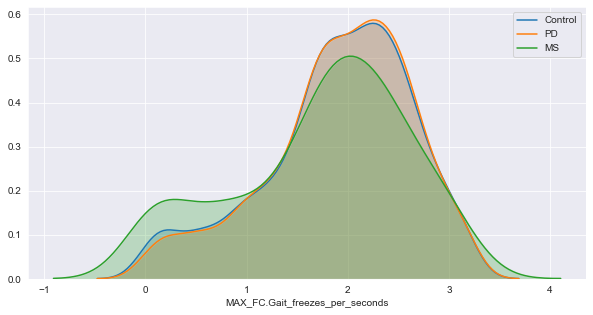

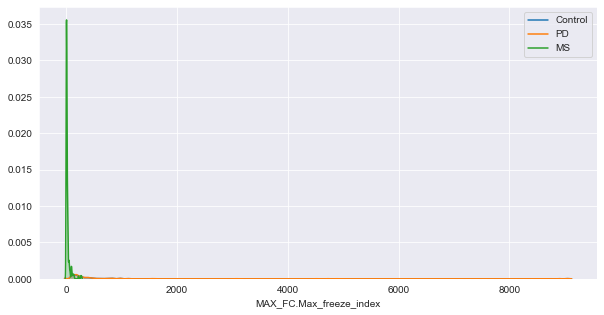

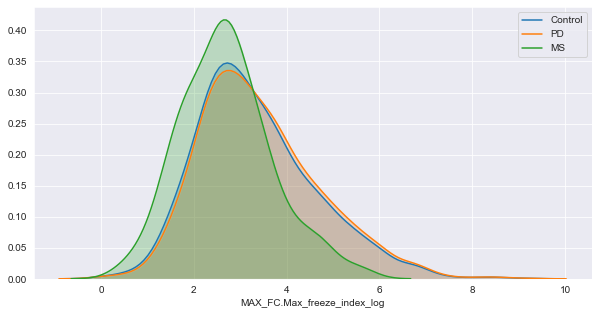

In [39]:
for feature in [feat for feat in max_grouped_data.columns if ("FC" in feat)]:
    viz.visualize_groupComparisons(max_grouped_data[max_grouped_data["version"] != "mpower_passive"], feature)

## 7.) PD-ACTIVE vs PD-PASSIVE (per recordIds)

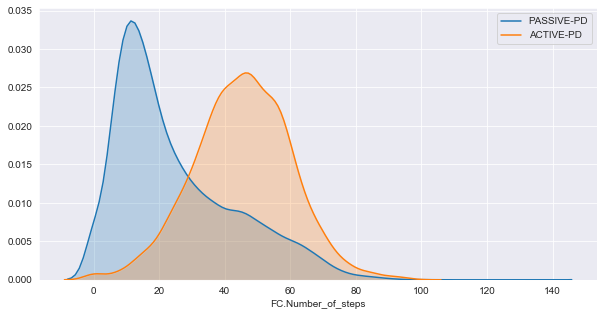

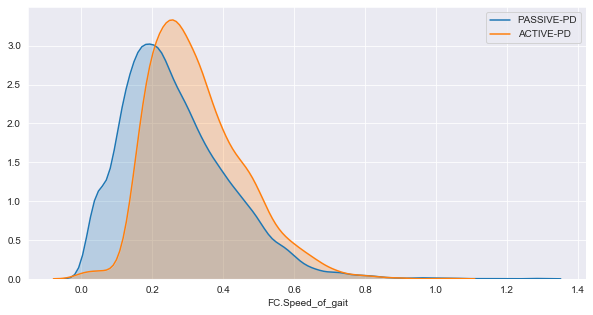

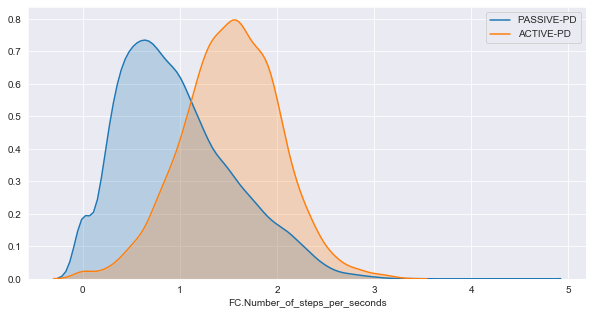

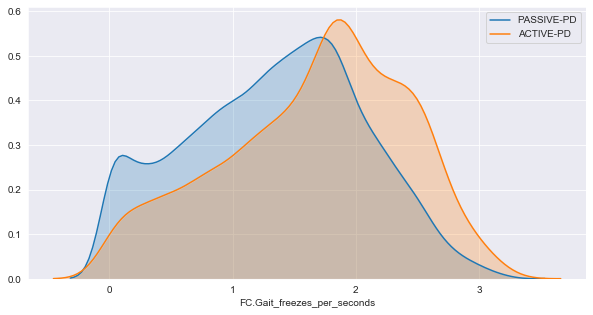

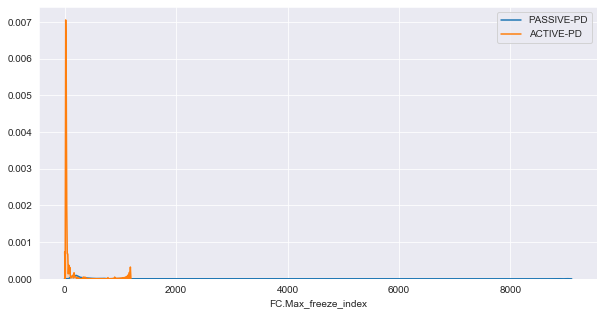

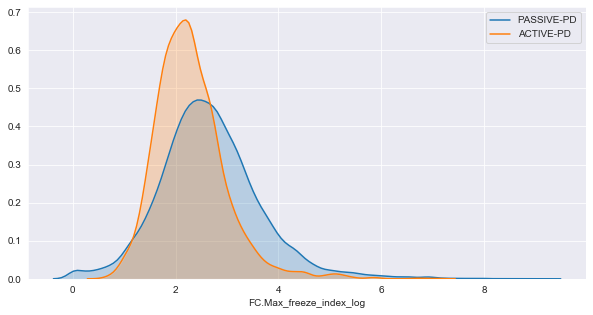

In [40]:
for feature in [feat for feat in data.columns if "FC" in feat]:
    viz.visualize_passive_active(data, feature)

## 8.) PD-ACTIVE vs PD-PASSIVE (per healthCode Median)

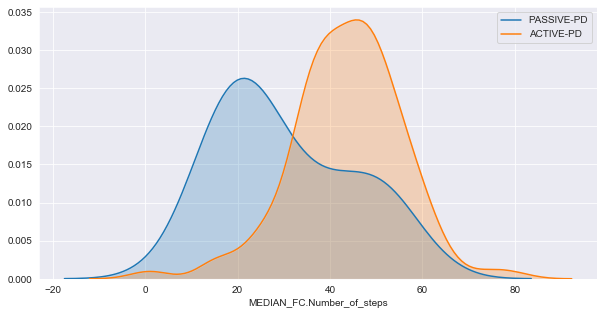

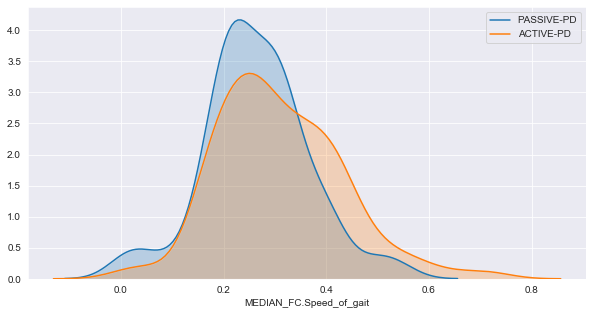

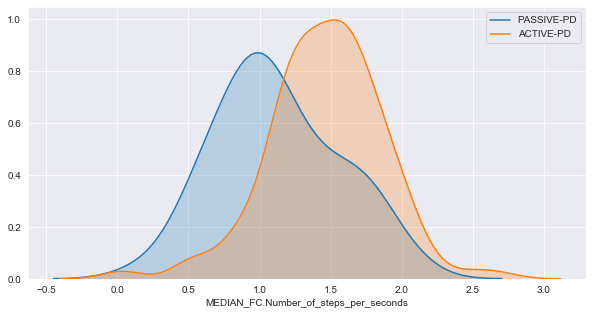

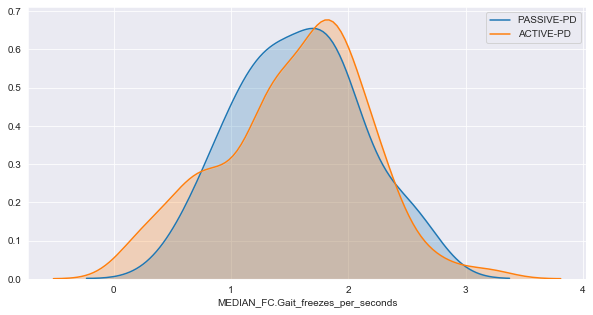

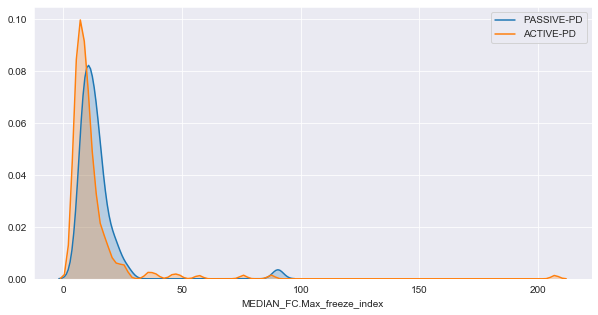

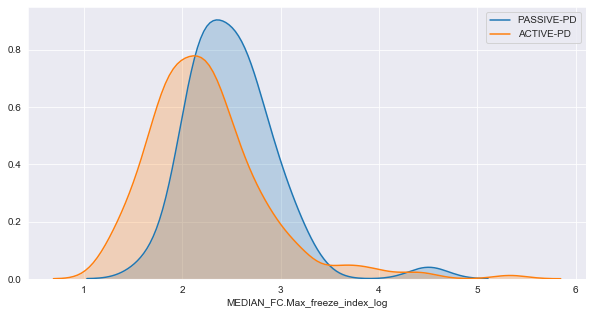

In [26]:
for feature in [feat for feat in median_grouped_data.columns if "FC" in feat]:
    viz.visualize_passive_active(median_grouped_data, feature)

## 9.) PD-ACTIVE vs PD-PASSIVE (per healthCode Maximums)

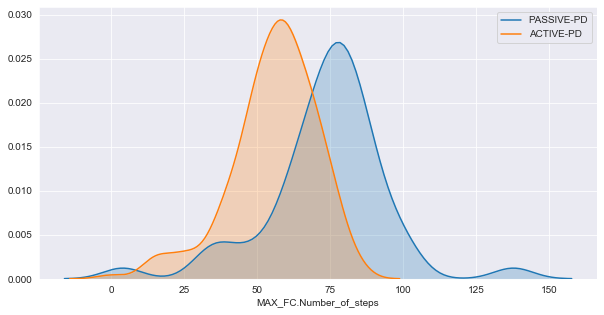

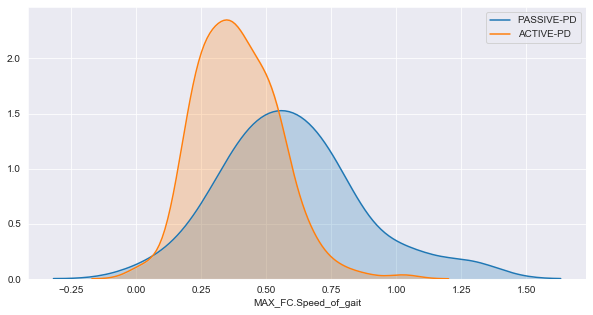

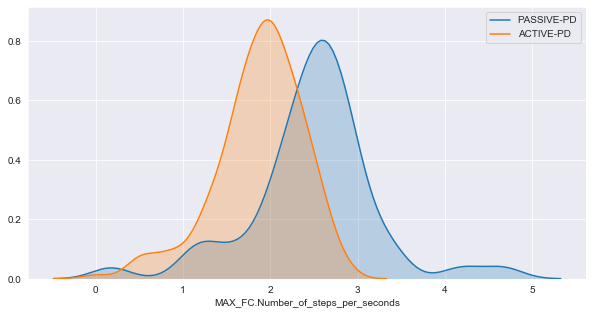

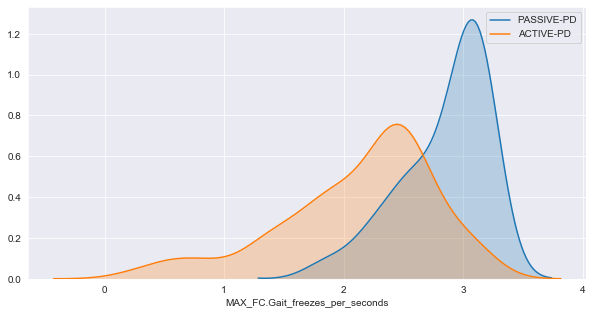

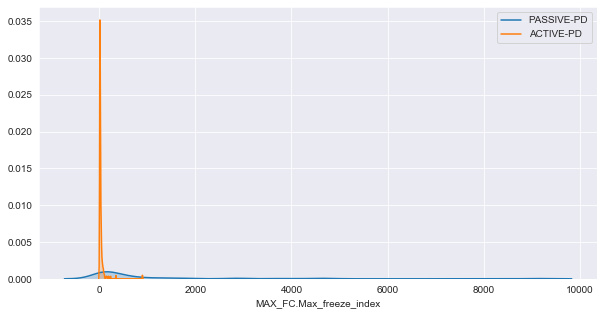

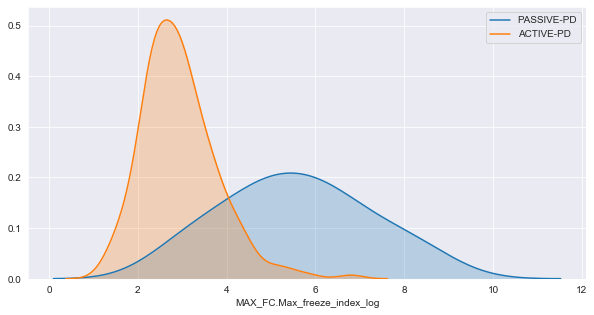

In [27]:
for feature in [feat for feat in max_grouped_data.columns if "FC" in feat]:
    viz.visualize_passive_active(max_grouped_data, feature)

## 10). Which of the features have strong attribute in determining PD?
In this analysis, we will explore how each features are able to predict parkinson and non-parkinson and MS in terms of its separation.